In [3]:
# =========================
# Minimal NumPy MLP (XOR)
# =========================
import numpy as np
from abc import ABC, abstractmethod
from typing import List

np.random.seed(42)

# --- Activation functions ---
class ActivationFunction(ABC):
    @abstractmethod
    def output(self, z: np.ndarray) -> np.ndarray: ...
    @abstractmethod
    def derivative(self, z: np.ndarray) -> np.ndarray: ...

class Sigmoid(ActivationFunction):
    def output(self, z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))
    def derivative(self, z: np.ndarray) -> np.ndarray:
        a = self.output(z)
        return a * (1.0 - a)

class ReLU(ActivationFunction):
    def output(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0.0, z)
    def derivative(self, z: np.ndarray) -> np.ndarray:
        return (z > 0.0).astype(z.dtype)

class WeightedReLU(ActivationFunction):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha
    def output(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0.0, z, self.alpha * z)
    def derivative(self, z: np.ndarray) -> np.ndarray:
        return np.where(z > 0.0, 1.0, self.alpha)

class Tanh(ActivationFunction):
    def output(self, z: np.ndarray) -> np.ndarray:
        return np.tanh(z)
    def derivative(self, z: np.ndarray) -> np.ndarray:
        a = np.tanh(z)
        return 1.0 - a * a

# --- Cost functions ---
class CostFunction(ABC):
    @abstractmethod
    def value(self, y_true: np.ndarray, y_pred: np.ndarray) -> float: ...
    @abstractmethod
    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray: ...

class MeanSquared(CostFunction):
    def value(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return float(np.mean((y_pred - y_true) ** 2))
    def derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        m = y_true.shape[0]
        return (y_pred - y_true) / m  # dL/dy_pred

# --- Perceptron (one neuron) ---
class Perceptron:
    def __init__(self, input_size: int, activation: ActivationFunction):
        # Xavier-ish scaling helps for tanh/sigmoid
        limit = np.sqrt(6.0 / (input_size + 1))
        self.weights = np.random.uniform(-limit, limit, size=(input_size, 1))
        self.bias = np.zeros((1, 1))
        self.activation = activation
        self.z = None
        self.a = None

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        self.z = X @ self.weights + self.bias        # (B,1)
        self.a = self.activation.output(self.z)      # (B,1)
        return self.a

    def backward(self, X: np.ndarray, error: np.ndarray, learning_rate: float) -> np.ndarray:
        # error is dL/da for this neuron
        dz = error * self.activation.derivative(self.z)  # (B,1)
        dW = X.T @ dz                                    # (in,1)
        db = np.sum(dz, axis=0, keepdims=True)           # (1,1)
        # gradient descent
        self.weights -= learning_rate * dW
        self.bias   -= learning_rate * db
        # upstream gradient to previous layer: dL/dX
        return dz @ self.weights.T                       # (B,in)

# --- Dense layer ---
class Layer:
    def __init__(self, input_size: int, num_neurons: int, activation: ActivationFunction):
        self.perceptrons = [Perceptron(input_size, activation) for _ in range(num_neurons)]
        self.input_size = input_size
        self.num_neurons = num_neurons

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([p.feedforward(X) for p in self.perceptrons], axis=1)  # (B,N)

    def backward(self, X: np.ndarray, errors: np.ndarray, learning_rate: float) -> np.ndarray:
        # errors: (B,N) for this layer's activations
        grads_to_prev = []
        for i, p in enumerate(self.perceptrons):
            e_i = errors[:, i:i+1]                       # (B,1)
            grads_to_prev.append(p.backward(X, e_i, learning_rate))  # (B,in)
        # sum contributions across neurons
        return np.sum(grads_to_prev, axis=0)             # (B,in)

# --- Network ---
class NeuralNetwork:
    def __init__(self, layers: List[Layer], cost: CostFunction):
        self.layers = layers
        self.cost = cost

    def _forward_all(self, X: np.ndarray) -> List[np.ndarray]:
        activations = [X]
        for layer in self.layers:
            activations.append(layer.feedforward(activations[-1]))
        return activations

    def train(self, input_data: np.ndarray, target_data: np.ndarray, epochs: int, learning_rate: float) -> None:
        for _ in range(epochs):
            acts = self._forward_all(input_data)
            y_pred = acts[-1]
            error = self.cost.derivative(target_data, y_pred)  # dL/dy_pred
            for layer, A_prev in zip(reversed(self.layers), reversed(acts[:-1])):
                error = layer.backward(A_prev, error, learning_rate)

    def predict(self, input_data: np.ndarray) -> np.ndarray:
        a = input_data
        for layer in self.layers:
            a = layer.feedforward(a)
        return a

# --- Training monitor ---
class TrainingMonitor:
    def __init__(self):
        self.loss_history: List[float] = []

    def monitor_training(self, neural_network: NeuralNetwork,
                         input_data: np.ndarray,
                         target_data: np.ndarray,
                         epochs: int,
                         learning_rate: float) -> None:
        self.loss_history.clear()
        for epoch in range(epochs):
            neural_network.train(input_data, target_data, 1, learning_rate)
            y_hat = neural_network.predict(input_data)
            loss = neural_network.cost.value(target_data, y_hat)
            self.loss_history.append(loss)
        print("Training complete.")

Training complete.


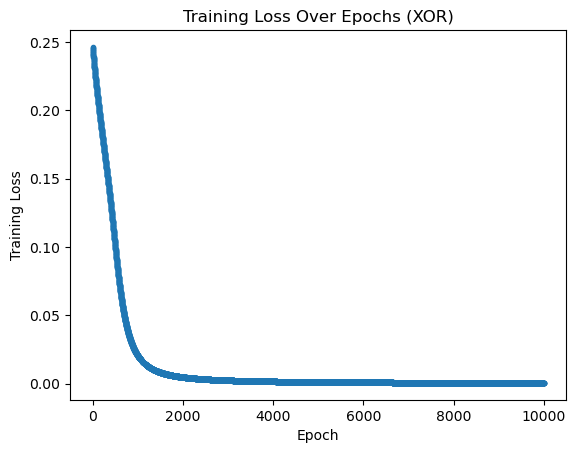

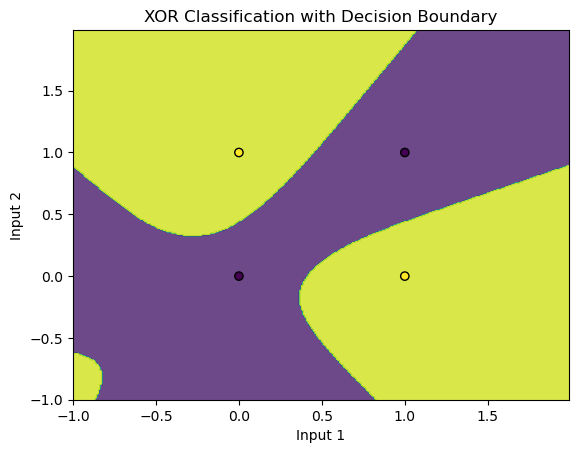

Predictions on XOR inputs:
[[0.013]
 [0.975]
 [0.979]
 [0.025]]


In [4]:
import matplotlib.pyplot as plt

# =========================
# XOR demo (0/1 targets)
# =========================

# Training data for XOR
input_data_xor = np.array([[0, 0],
                           [0, 1],
                           [1, 0],
                           [1, 1]], dtype=float)
target_data_xor = np.array([[0],
                            [1],
                            [1],
                            [0]], dtype=float)

# Build network (Sigmoid at output for 0/1 targets)
nn_xor = NeuralNetwork([
    Layer(2, 5, Tanh()),
    Layer(5, 5, Tanh()),
    Layer(5, 1, Sigmoid()),   # <-- Sigmoid works best for binary 0/1
], MeanSquared())

# Train with monitoring
monitor_xor = TrainingMonitor()
monitor_xor.monitor_training(nn_xor, input_data_xor, target_data_xor, epochs=10000, learning_rate=0.1)

# Plot loss
plt.figure()
plt.plot(range(1, len(monitor_xor.loss_history) + 1), monitor_xor.loss_history, marker='.')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs (XOR)')
plt.show()

# Decision boundary plot
h_xor = 0.01
x_min_xor, x_max_xor = input_data_xor[:, 0].min() - 1, input_data_xor[:, 0].max() + 1
y_min_xor, y_max_xor = input_data_xor[:, 1].min() - 1, input_data_xor[:, 1].max() + 1
xx_xor, yy_xor = np.meshgrid(np.arange(x_min_xor, x_max_xor, h_xor),
                             np.arange(y_min_xor, y_max_xor, h_xor))
grid_xor = np.c_[xx_xor.ravel(), yy_xor.ravel()]

Z_xor = (nn_xor.predict(grid_xor) >= 0.5).astype(int).reshape(xx_xor.shape)

plt.figure()
plt.contourf(xx_xor, yy_xor, Z_xor, alpha=0.8)
plt.scatter(input_data_xor[:, 0], input_data_xor[:, 1], c=target_data_xor.ravel(), edgecolors='k')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('XOR Classification with Decision Boundary')
plt.show()

# Quick sanity check on the 4 points
print("Predictions on XOR inputs:")
print(np.round(nn_xor.predict(input_data_xor), 3))